# Skin Lesion Classification using Machine Learning
This project aims to classify skin lesions as **malignant** or **benign** using deep learning techniques on the **ISIC 2020 Challenge dataset**. The final model will be considered for integration into a mobile application.

## Objectives
- Preprocess and analyze the ISIC 2020 dataset
- Train a convolutional neural network
- Evaluate the model using appropriate metrics
- Prepare the model for mobile deployment


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from focal_loss import BinaryFocalLoss


print("Modules Installed Succsessfully")
print("Tensorflow Version: ", tf.__version__)

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)



Modules Installed Succsessfully
Tensorflow Version:  2.19.0
Available GPUs: []


In [2]:
from tensorflow.python.platform import build_info as tf_build_info
print("TF Build Info:", tf_build_info.build_info)


TF Build Info: OrderedDict({'is_cuda_build': False, 'is_rocm_build': False, 'is_tensorrt_build': False, 'msvcp_dll_names': 'msvcp140.dll,msvcp140_1.dll'})


In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Detected GPUs:", gpus)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)
else:
    print("⚠️ No GPU detected by TensorFlow")


Detected GPUs: []
⚠️ No GPU detected by TensorFlow


## Dataset Preparation

We load the metadata from the ISIC 2020 competition and associate each image with a binary label:
- `0` = Benign
- `1` = Malignant


In [4]:
CSV_PATH = '../data/train.csv'
IMAGE_DIR = '../data/jpeg/train'

df = pd.read_csv(CSV_PATH)
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(IMAGE_DIR, f"{x}.jpg"))
df['label'] = df['target'].apply(lambda x: 'malignant' if x == 1 else 'benign')
df.head(10)

df['label'].value_counts()



label
benign       32542
malignant      584
Name: count, dtype: int64

## Class Distribution

The dataset is imbalanced, with far more benign cases than malignant. We'll use data augmentation to help mitigate this.


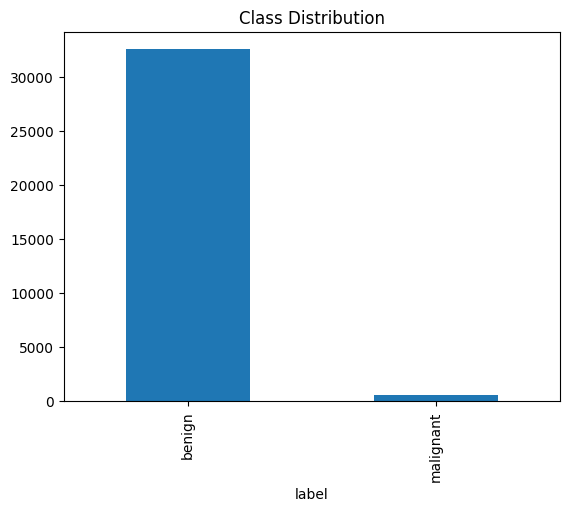

In [5]:
df['label'].value_counts().plot(kind='bar', title='Class Distribution');


## Data Augmentation and Preprocessing

We split the dataset into training and validation sets, and apply augmentation to the training data to improve generalization.

#-> Serious Class imabalnces

In [6]:
# Toggle fast mode ON for quick testing or OFF for full functionality
# Set to True for fast mode, False for full functionality
FAST_MODE = False


In [7]:
# Original fast mode toggle

# if FAST_MODE:
#     # Sample a small subset for faster testing
#     df_small, _ = train_test_split(df, train_size=2000, stratify=df['label'], random_state=42)
#     train_df, val_df = train_test_split(df_small, test_size=0.2, stratify=df_small['label'], random_state=42)
#     print("⚡ FAST_MODE enabled: Using 2,000 samples.")
# else:
#     train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
#     print("✅ FAST_MODE disabled: Using full dataset.")

In [8]:
#Fast Mode toggle with oversampling

if FAST_MODE:
    # Sample a small subset for faster testing
    df_small, _ = train_test_split(df, train_size=2000, stratify=df['label'], random_state=42)
    train_df, val_df = train_test_split(df_small, test_size=0.3, stratify=df_small['label'], random_state=42)
    print("⚡ FAST_MODE enabled: Using 2,000 samples.")

else:
    # Full dataset split
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    print("✅ FAST_MODE disabled: Using full dataset.")

# --- Oversample (for BOTH modes) ---
benign_df = train_df[train_df['label'] == 'benign']
malignant_df = train_df[train_df['label'] == 'malignant']

# Oversample malignant to match benign count
malignant_oversampled = malignant_df.sample(n=len(benign_df), replace=True, random_state=42)

# Combine and shuffle
train_df = pd.concat([benign_df, malignant_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Print result
print("\nBalanced Training Set:")
print(train_df['label'].value_counts())

print("\nValidation Set:")
print(val_df['label'].value_counts())



✅ FAST_MODE disabled: Using full dataset.

Balanced Training Set:
label
benign       26033
malignant    26033
Name: count, dtype: int64

Validation Set:
label
benign       6509
malignant     117
Name: count, dtype: int64


In [9]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)


val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

train_df['label'].value_counts()



Found 52066 validated image filenames belonging to 2 classes.
Found 6626 validated image filenames belonging to 2 classes.


label
benign       26033
malignant    26033
Name: count, dtype: int64

## Model Performance Visualization

To better understand how each model learns over time, we plot both:
- Training vs. Validation **Accuracy**
- Training vs. Validation **Loss**

This helps us diagnose issues like overfitting or underfitting.

In [10]:
# def plot_training_history(history, model_name="Model"):
#     epochs = range(1, len(history.history['accuracy']) + 1)
#     num_subplots = 4 if 'auc' in history.history else 3

#     plt.figure(figsize=(16, 12))

#     # Accuracy
#     plt.subplot(2, 2, 1)
#     plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
#     plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
#     plt.title(f'{model_name} - Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Loss
#     plt.subplot(2, 2, 2)
#     plt.plot(epochs, history.history['loss'], label='Train Loss')
#     plt.plot(epochs, history.history['val_loss'], label='Val Loss')
#     plt.title(f'{model_name} - Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Precision
#     if 'precision' in history.history:
#         plt.subplot(2, 2, 3)
#         plt.plot(epochs, history.history['precision'], label='Train Precision')
#         plt.plot(epochs, history.history['val_precision'], label='Val Precision')
#         plt.title(f'{model_name} - Precision')
#         plt.xlabel('Epochs')
#         plt.ylabel('Precision')
#         plt.legend()

#     # Recall or AUC (slot 4)
#     if 'recall' in history.history:
#         plt.subplot(2, 2, 4)
#         plt.plot(epochs, history.history['recall'], label='Train Recall')
#         plt.plot(epochs, history.history['val_recall'], label='Val Recall')
#         plt.title(f'{model_name} - Recall')
#         plt.xlabel('Epochs')
#         plt.ylabel('Recall')
#         plt.legend()

#     # AUC (if present, draw it in a new figure if needed)
#     if 'auc' in history.history:
#         plt.figure(figsize=(7, 5))
#         plt.plot(epochs, history.history['auc'], label='Train AUC')
#         plt.plot(epochs, history.history['val_auc'], label='Val AUC')
#         plt.title(f'{model_name} - AUC')
#         plt.xlabel('Epochs')
#         plt.ylabel('AUC')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
#     else:
#         plt.tight_layout()
#         plt.show()

def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    metrics_to_plot = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    available_metrics = [m for m in metrics_to_plot if f'val_{m}' in history.history]

    total = len(available_metrics)
    cols = 2
    rows = (total + 1) // cols

    plt.figure(figsize=(6 * cols, 4 * rows))

    for i, metric in enumerate(available_metrics, 1):
        plt.subplot(rows, cols, i)
        plt.plot(epochs, history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(epochs, history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'{model_name} - {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()



## Model 1: MobileNetV2

MobileNetV2 is a type of computer model designed to look at pictures and make decisions, like identifying whether a skin lesion is cancerous or not. 

What makes MobileNetV2 special is that it's very **fast and lightweight**, which means it can run efficiently on mobile phones and small devices — not just on powerful computers. Even though it’s small, it’s still smart enough to give reliable results by learning from thousands of examples.

Because of its speed and accuracy, it’s a great choice for building health apps that can help detect skin problems directly from your phone.


In [11]:
#Build Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [12]:
EPOCHS = 6 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_skin_lesion.h5', save_best_only=True)
]

history_mobilenet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


c:\Dissertation\SkinLesionClassifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.7229 - auc: 0.7981 - loss: 0.5434 - precision: 0.7180 - recall: 0.7319

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1767s 1s/step - accuracy: 0.7229 - auc: 0.7981 - loss: 0.5434 - precision: 0.7180 - recall: 0.7319 - val_accuracy: 0.7555 - val_auc: 0.8329 - val_loss: 0.4498 - val_precision: 0.0519 - val_recall: 0.7436
Epoch 2/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1738s 1s/step - accuracy: 0.7798 - auc: 0.8639 - loss: 0.4549 - precision: 0.7643 - recall: 0.8096 - val_accuracy: 0.6853 - val_auc: 0.8309 - val_loss: 0.5542 - val_precision: 0.0436 - val_recall: 0.8034
Epoch 3/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.8014 - auc: 0.8840 - loss: 0.4247 - precision: 0.7819 - recall: 0.8333

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1742s 1s/step - accuracy: 0.8014 - auc: 0.8840 - loss: 0.4247 - precision: 0.7819 - recall: 0.8333 - val_accuracy: 0.7855 - val_auc: 0.8242 - val_loss: 0.4012 - val_precision: 0.0559 - val_recall: 0.7009
Epoch 4/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.8117 - auc: 0.8937 - loss: 0.4060 - precision: 0.7910 - recall: 0.8459

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1706s 1s/step - accuracy: 0.8117 - auc: 0.8937 - loss: 0.4060 - precision: 0.7910 - recall: 0.8459 - val_accuracy: 0.8329 - val_auc: 0.8284 - val_loss: 0.3287 - val_precision: 0.0635 - val_recall: 0.6154


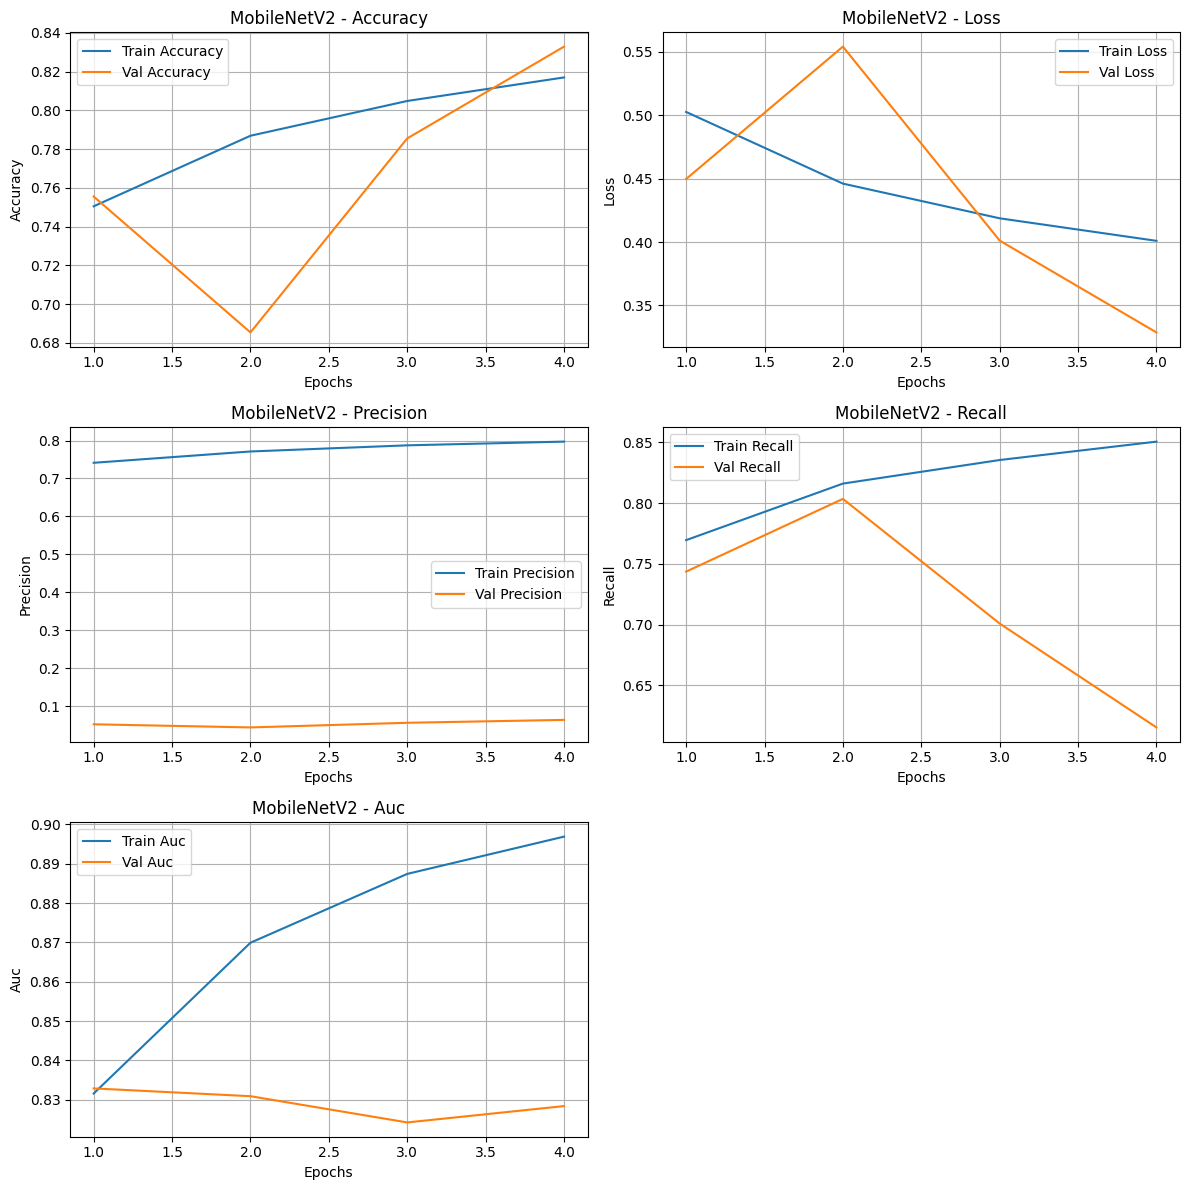

In [13]:
# plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
# plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
# plt.title('MobileNetV2 Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

plot_training_history(history_mobilenet, model_name="MobileNetV2")
model.save('mobilenetv2_skin_classifier.h5')



## Model 2: EfficientNetB0

EfficientNetB0 is a state-of-the-art convolutional neural network architecture that balances high accuracy with computational efficiency. It uses a novel scaling method that adjusts width, depth, and resolution in a balanced way, making it well-suited for real-world applications like skin lesion classification on mobile devices.

- EfficientNetB0 trains slightly slower than MobileNetV2 but often achieves higher validation accuracy.
- Final model choice will be based on a trade-off between accuracy, speed, and mobile deployment feasibility.

In [14]:
# EfficientNetB0 base model setup
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for feature extraction

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [15]:
EPOCHS = 3 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('efficientnetb0_skin_lesion.h5', save_best_only=True)
]

history_effnet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.5029 - auc: 0.5060 - loss: 0.6967 - precision: 0.5061 - recall: 0.5457

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1795s 1s/step - accuracy: 0.5029 - auc: 0.5060 - loss: 0.6967 - precision: 0.5061 - recall: 0.5456 - val_accuracy: 0.9823 - val_auc: 0.5000 - val_loss: 0.6858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1800s 1s/step - accuracy: 0.4964 - auc: 0.4915 - loss: 0.6932 - precision: 0.4736 - recall: 0.1436 - val_accuracy: 0.0177 - val_auc: 0.5000 - val_loss: 0.6934 - val_precision: 0.0177 - val_recall: 1.0000
Epoch 3/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.5039 - auc: 0.4997 - loss: 0.6932 - precision: 0.5056 - recall: 0.4891

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1792s 1s/step - accuracy: 0.5039 - auc: 0.4997 - loss: 0.6932 - precision: 0.5056 - recall: 0.4891 - val_accuracy: 0.9823 - val_auc: 0.5000 - val_loss: 0.6826 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1794s 1s/step - accuracy: 0.4933 - auc: 0.4964 - loss: 0.6933 - precision: 0.4518 - recall: 0.3672 - val_accuracy: 0.9823 - val_auc: 0.5000 - val_loss: 0.6899 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


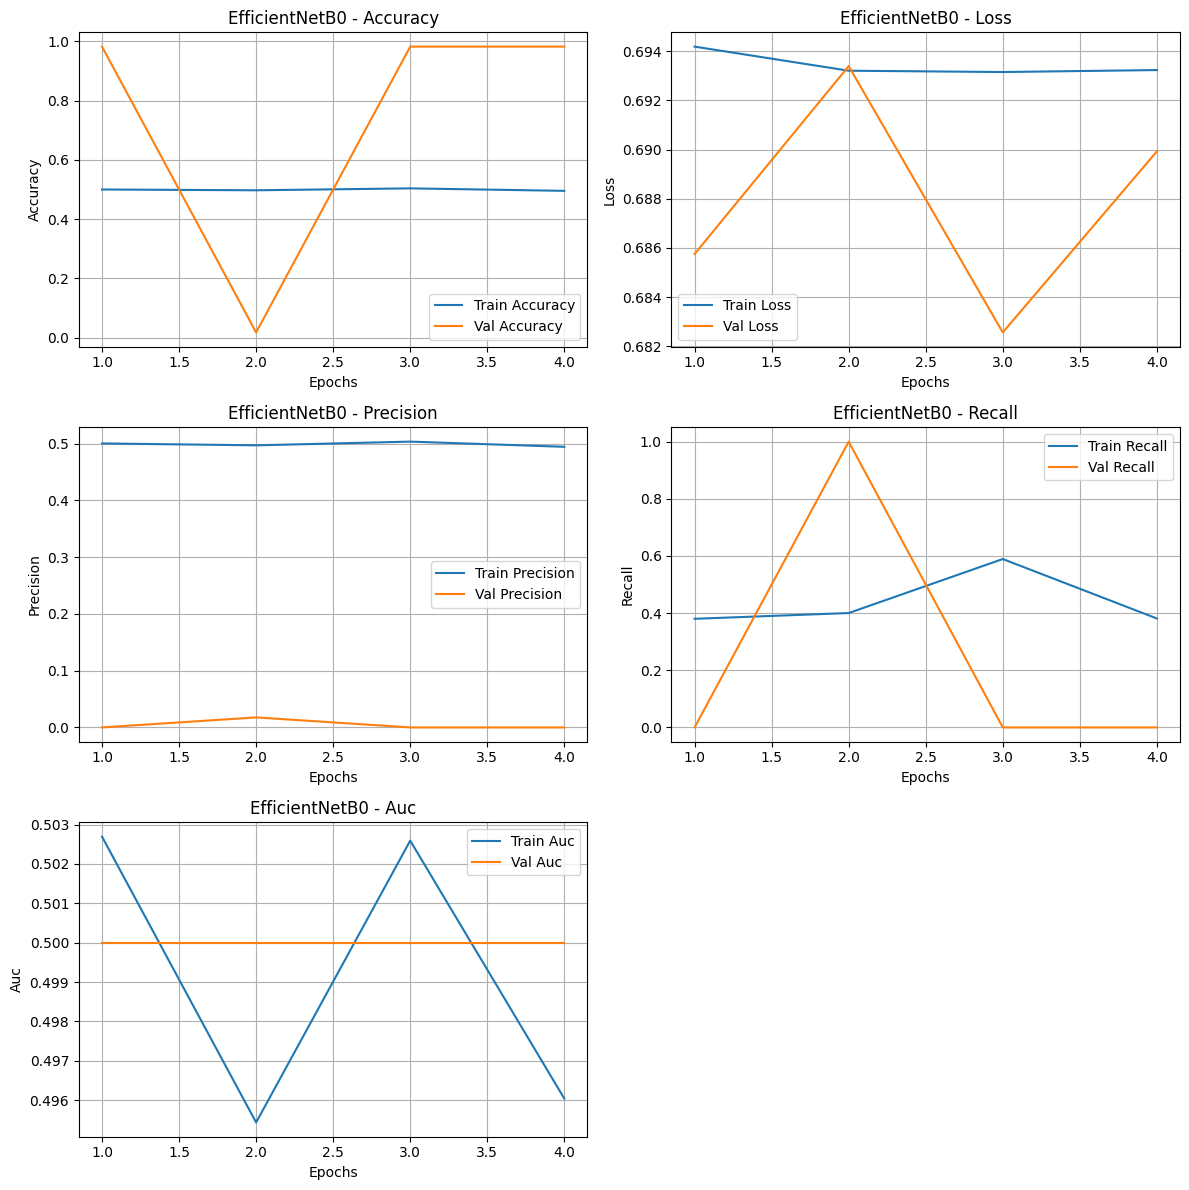

In [16]:
# plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')
# plt.plot(history_effnet.history['val_accuracy'], label='Val Accuracy')
# plt.title('EfficientNetB0 Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
model.save('efficientnetb0_skin_lesion.h5')
plot_training_history(history_effnet, model_name="EfficientNetB0")



## Model 3: ResNet50

ResNet50 (Residual Network) is a deep convolutional neural network that introduces **skip connections**, allowing the model to train very deep architectures without suffering from vanishing gradients. It’s widely used in medical image classification due to its high accuracy and stable training behavior.


In [17]:
# ResNet50 base model setup
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for feature extraction

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [18]:
EPOCHS = 3 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('resnet50_skin_lesion.h5', save_best_only=True)
]

history_resnet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5009 - auc: 0.5018 - loss: 0.7154 - precision: 0.4995 - recall: 0.4914

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 2108s 1s/step - accuracy: 0.5009 - auc: 0.5018 - loss: 0.7154 - precision: 0.4995 - recall: 0.4915 - val_accuracy: 0.9795 - val_auc: 0.6188 - val_loss: 0.6884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5170 - auc: 0.5271 - loss: 0.6918 - precision: 0.5174 - recall: 0.4932

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 2118s 1s/step - accuracy: 0.5170 - auc: 0.5271 - loss: 0.6918 - precision: 0.5174 - recall: 0.4932 - val_accuracy: 0.9502 - val_auc: 0.6827 - val_loss: 0.6410 - val_precision: 0.0390 - val_recall: 0.0769
Epoch 3/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 2114s 1s/step - accuracy: 0.5480 - auc: 0.5710 - loss: 0.6843 - precision: 0.5508 - recall: 0.5508 - val_accuracy: 0.7140 - val_auc: 0.6888 - val_loss: 0.6651 - val_precision: 0.0346 - val_recall: 0.5641
Epoch 4/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 2095s 1s/step - accuracy: 0.5692 - auc: 0.5971 - loss: 0.6768 - precision: 0.5723 - recall: 0.5505 - val_accuracy: 0.7718 - val_auc: 0.6841 - val_loss: 0.6413 - val_precision: 0.0365 - val_recall: 0.4701
Epoch 5/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 2105s 1s/step - accuracy: 0.5764 - auc: 0.6117 - loss: 0.6719 - precision: 0.5829 - recall: 0.5473 - val_accuracy: 0.1944 - val_auc: 0.6849 - val_loss: 0.7649 - val_precision: 0.0202 - val_recall: 0.9402
Epoch 6/10
1628/1628 ━━━━━━

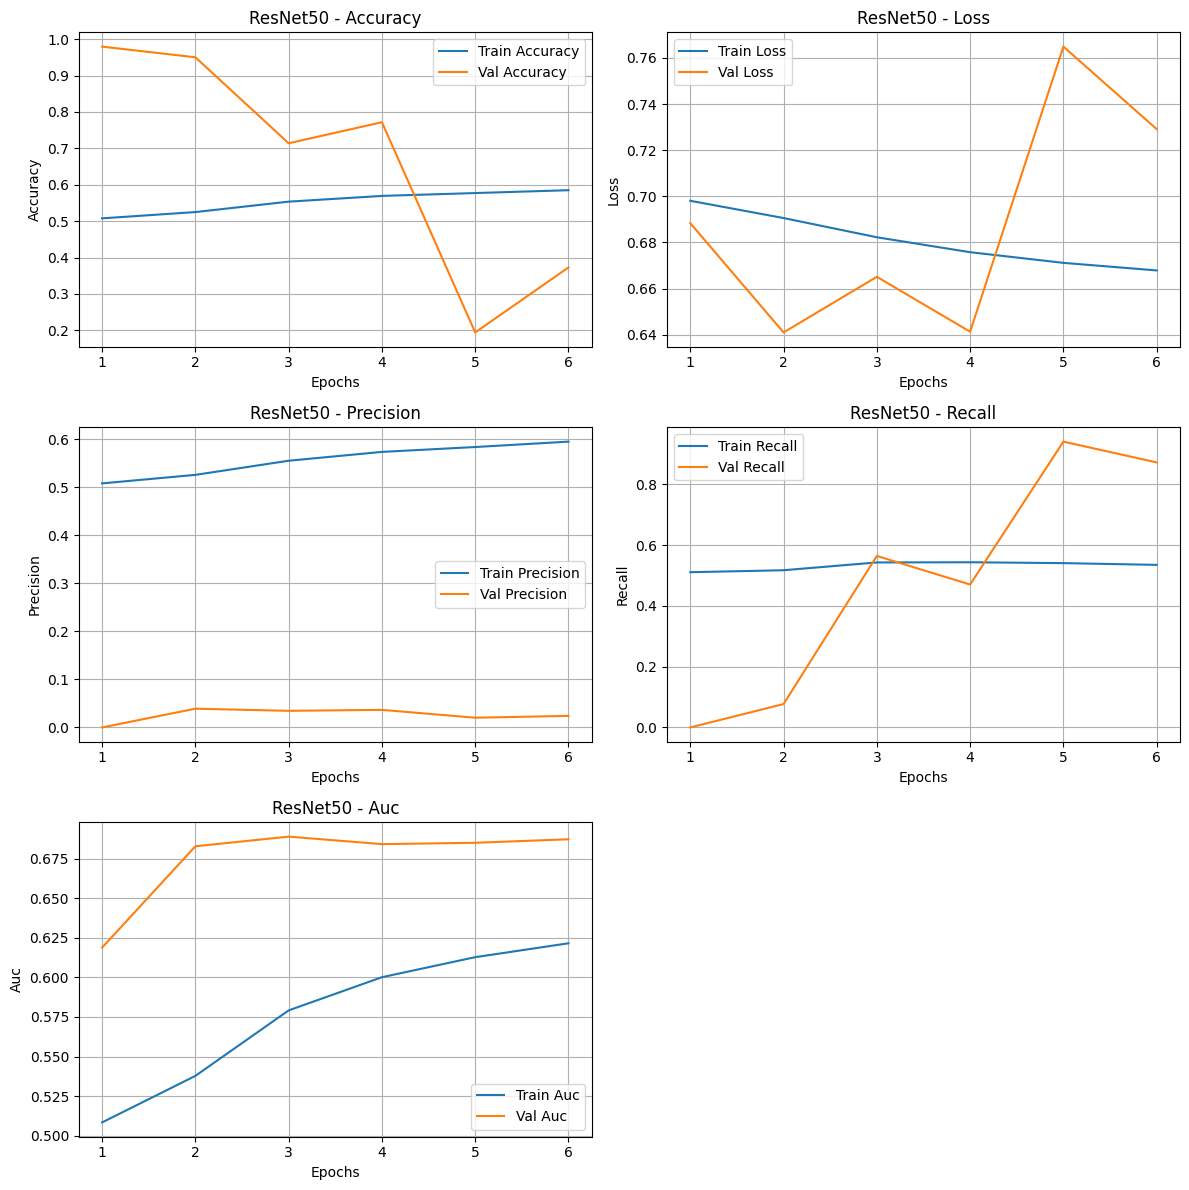

In [19]:
model.save('resnet50_skin_classifier.h5')
plot_training_history(history_resnet, model_name="ResNet50")


## Model 4: InceptionV3

InceptionV3 is a deep convolutional neural network that uses multiple filter sizes within the same layer, allowing it to learn both fine and coarse features. It was designed to achieve high accuracy while keeping computational cost manageable. InceptionV3 is particularly good for recognizing complex image patterns, making it suitable for medical image classification.


In [20]:
# InceptionV3 base model setup
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for feature extraction

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [21]:
EPOCHS = 3 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('inceptionv3_skin_lesion.h5', save_best_only=True)
]

history_inception = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.7014 - auc: 0.7733 - loss: 0.5720 - precision: 0.6978 - recall: 0.7168

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1872s 1s/step - accuracy: 0.7014 - auc: 0.7734 - loss: 0.5720 - precision: 0.6978 - recall: 0.7168 - val_accuracy: 0.7199 - val_auc: 0.8156 - val_loss: 0.5105 - val_precision: 0.0483 - val_recall: 0.7949
Epoch 2/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7524 - auc: 0.8329 - loss: 0.5003 - precision: 0.7355 - recall: 0.7891

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1900s 1s/step - accuracy: 0.7524 - auc: 0.8329 - loss: 0.5003 - precision: 0.7355 - recall: 0.7891 - val_accuracy: 0.7105 - val_auc: 0.8146 - val_loss: 0.5093 - val_precision: 0.0477 - val_recall: 0.8120
Epoch 3/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7671 - auc: 0.8485 - loss: 0.4794 - precision: 0.7472 - recall: 0.8098

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1870s 1s/step - accuracy: 0.7671 - auc: 0.8485 - loss: 0.4794 - precision: 0.7473 - recall: 0.8098 - val_accuracy: 0.7217 - val_auc: 0.8207 - val_loss: 0.5023 - val_precision: 0.0453 - val_recall: 0.7350
Epoch 4/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.7775 - auc: 0.8585 - loss: 0.4649 - precision: 0.7565 - recall: 0.8182

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1844s 1s/step - accuracy: 0.7776 - auc: 0.8585 - loss: 0.4649 - precision: 0.7565 - recall: 0.8182 - val_accuracy: 0.7883 - val_auc: 0.8223 - val_loss: 0.4225 - val_precision: 0.0590 - val_recall: 0.7350
Epoch 5/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1841s 1s/step - accuracy: 0.7865 - auc: 0.8696 - loss: 0.4480 - precision: 0.7672 - recall: 0.8221 - val_accuracy: 0.7644 - val_auc: 0.8168 - val_loss: 0.4413 - val_precision: 0.0510 - val_recall: 0.7009
Epoch 6/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7983 - auc: 0.8781 - loss: 0.4354 - precision: 0.7768 - recall: 0.8366

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1903s 1s/step - accuracy: 0.7983 - auc: 0.8781 - loss: 0.4354 - precision: 0.7768 - recall: 0.8366 - val_accuracy: 0.8209 - val_auc: 0.8125 - val_loss: 0.3698 - val_precision: 0.0593 - val_recall: 0.6154
Epoch 7/10
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 1989s 1s/step - accuracy: 0.7991 - auc: 0.8794 - loss: 0.4318 - precision: 0.7786 - recall: 0.8365 - val_accuracy: 0.7866 - val_auc: 0.8081 - val_loss: 0.4044 - val_precision: 0.0506 - val_recall: 0.6239


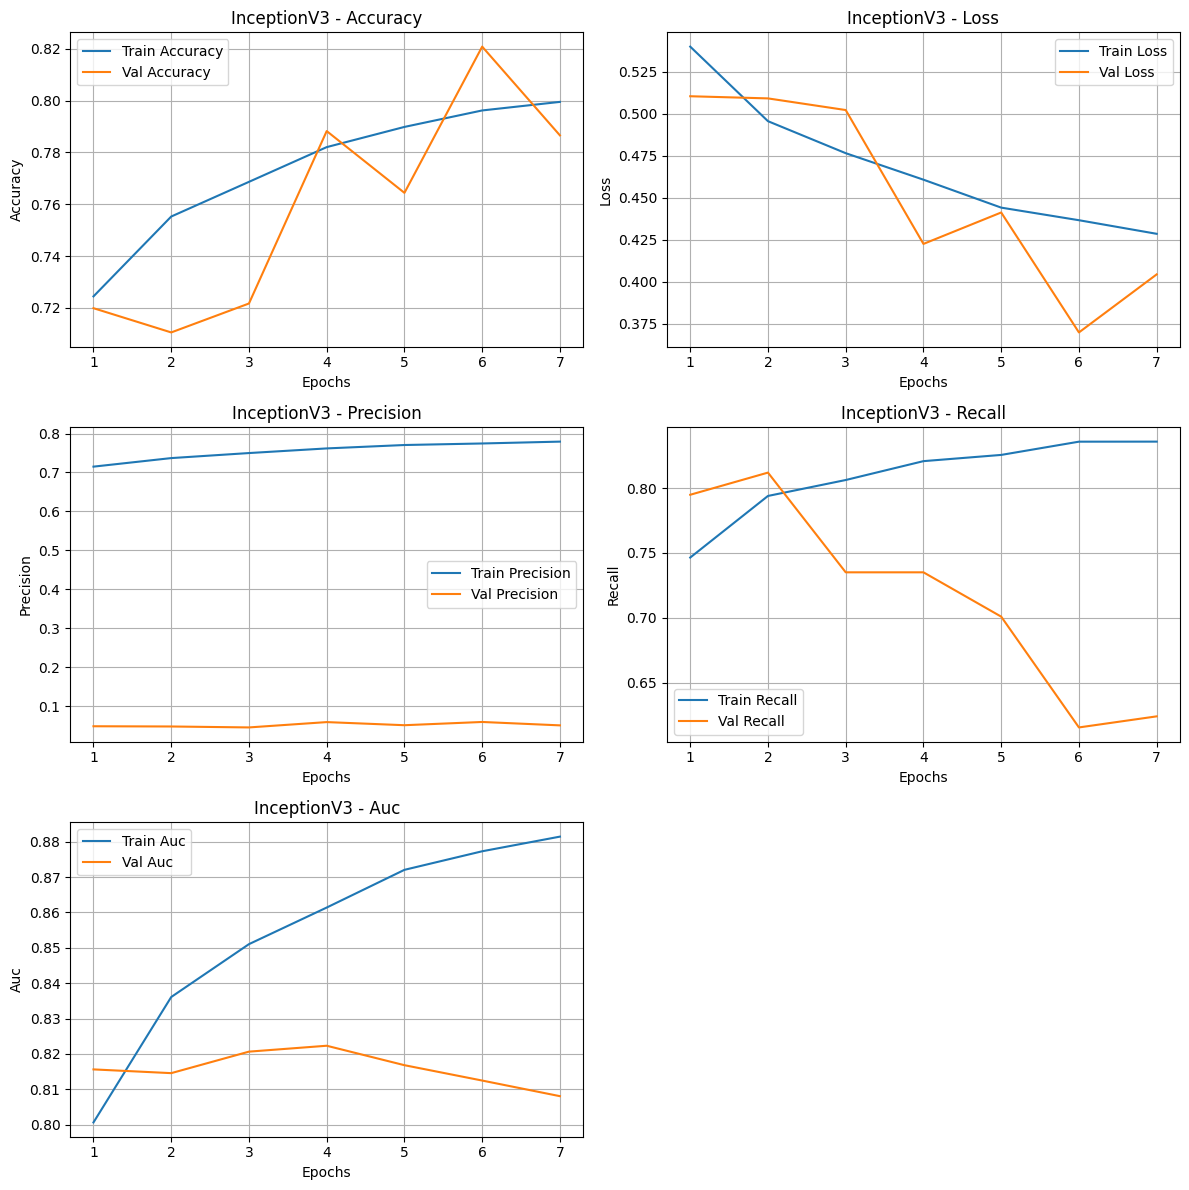

In [22]:
model.save('inceptionv3_skin_classifier.h5')
plot_training_history(history_inception, model_name="InceptionV3")


## Evaluation, Comparison, and Ranking

After training models, we evaluate their classification performance using standard metrics:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**
- **AUC (Area Under the ROC Curve)**

These metrics are calculated on the **validation dataset**, and used to compare model performance and rank the models objectively.


### Validation Accuracy Over Epochs

The plot below shows how each model's validation accuracy changed over training epochs. This helps identify which models learned efficiently, and which may have overfitted or plateaued early.


In [23]:
def plot_all_model_val_accuracy(histories):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all_model_val_auc(histories):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history.history['val_auc'], label=f'{name} Val Auc')
    
    plt.title('Validation AUC Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

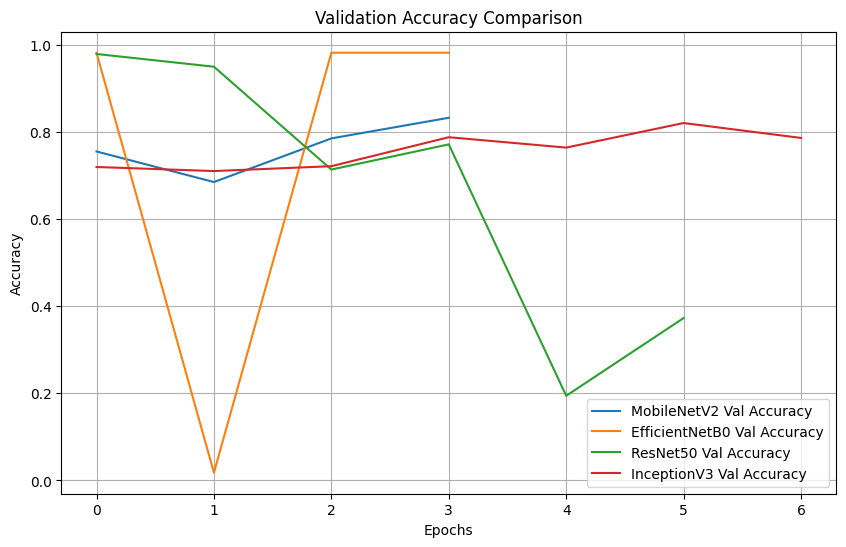

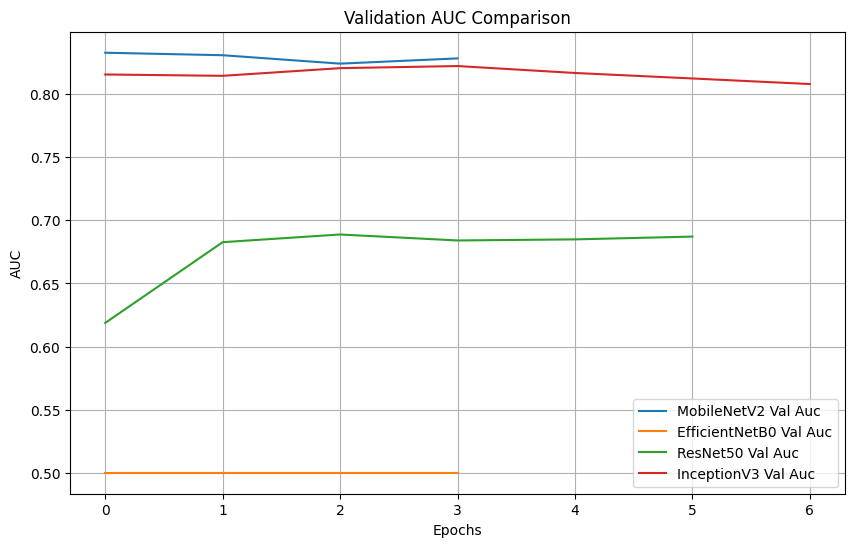

In [24]:
histories = {
    'MobileNetV2': history_mobilenet,
    'EfficientNetB0': history_effnet,
    'ResNet50': history_resnet,
    'InceptionV3': history_inception
}

plot_all_model_val_accuracy(histories)
plot_all_model_val_auc(histories)


### Evaluation Metrics Explained

- **Accuracy**: Proportion of total correct predictions
- **Precision**: Of the predicted positives, how many were correct
- **Recall**: Of all actual positives, how many were correctly predicted
- **F1-Score**: Balance between precision and recall
- **AUC**: Measures model’s ability to distinguish between classes

These metrics provide a comprehensive understanding of each model's strengths and weaknesses.


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred_probs = model.predict(generator, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)

    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc
    }


In [ ]:
results = {
    'MobileNetV2': evaluate_model(tf.keras.models.load_model('mobilenetv2_skin_lesion.h5'), val_gen),
    'EfficientNetB0': evaluate_model(tf.keras.models.load_model('efficientnetb0_skin_lesion.h5'), val_gen),
    'ResNet50': evaluate_model(tf.keras.models.load_model('resnet50_skin_lesion.h5'), val_gen),
    'InceptionV3': evaluate_model(tf.keras.models.load_model('inceptionv3_skin_lesion.h5'), val_gen),
}



c:\Dissertation\SkinLesionClassifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Results Summary Table

The table below shows the performance of all models, sorted by **AUC**, which is often the most reliable metric for binary classification in medical datasets.


In [27]:
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='AUC', ascending=False)
results_df.style.set_caption("Model Performance Comparison (Validation Set)").format("{:.4f}")


,Accuracy,Precision,Recall,F1-Score,AUC
MobileNetV2,0.8169,0.0168,0.1624,0.0304,0.5123
ResNet50,0.9487,0.0173,0.0342,0.0230,0.5021
EfficientNetB0,0.9823,0.0000,0.0000,0.0000,0.5000
InceptionV3,0.8064,0.0198,0.2051,0.0361,0.4980


In [29]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title(f'Confusion Matrix @ Threshold {threshold}')
# plt.show()
